## Preprocessing

In [1]:
import pandas as pd
import json
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load the data
with open("../data/sample_niagara_data_realistic.json", "r") as f:
    data = json.load(f)

df = pd.DataFrame(data)
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.set_index("timestamp", inplace=True)

# Resample to hourly averages
df = df.resample("1h").mean().dropna()

# Time-based features
df["hour"] = df.index.hour
df["dayofweek"] = df.index.dayofweek
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)

# Prepare data
X = df[["hour", "dayofweek", "is_weekend"]]
y = df["energy_kWh"]

## Linear Regression with Time-Based Features

In [2]:
# Train model
model = LinearRegression()
model.fit(X, y)

# Predict
df["prediction"] = model.predict(X)

# Evaluate
mse = mean_squared_error(y, df["prediction"])
r2 = r2_score(y, df["prediction"])

print("MSE:", mse)
print("R²:", r2)


MSE: 45.01784468093765
R²: 0.08143835576989755


## LSTM with Time-Based Features

2025-05-22 12:31:54.515635: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-22 12:31:54.516156: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-22 12:31:54.518534: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-22 12:31:54.525308: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747909914.536941   63643 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747909914.54

Epoch 1/100


E0000 00:00:1747909915.991013   63643 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1747909915.996795   63643 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/nils/anaconda3/envs/mqtt_broker/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2577 - val_loss: 0.2405
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2241 - val_loss: 0.2067
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2073 - val_loss: 0.1782
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1589 - val_loss: 0.1582
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1519 - val_loss: 0.1432
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1412 - val_loss: 0.1338
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1308 - val_loss: 0.1260
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1252 - val_loss: 0.1204
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1197 - val_loss: 0.1166
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1148 - val_loss: 0.1140
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1118 - val_loss: 0.1119
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1062 - val_l

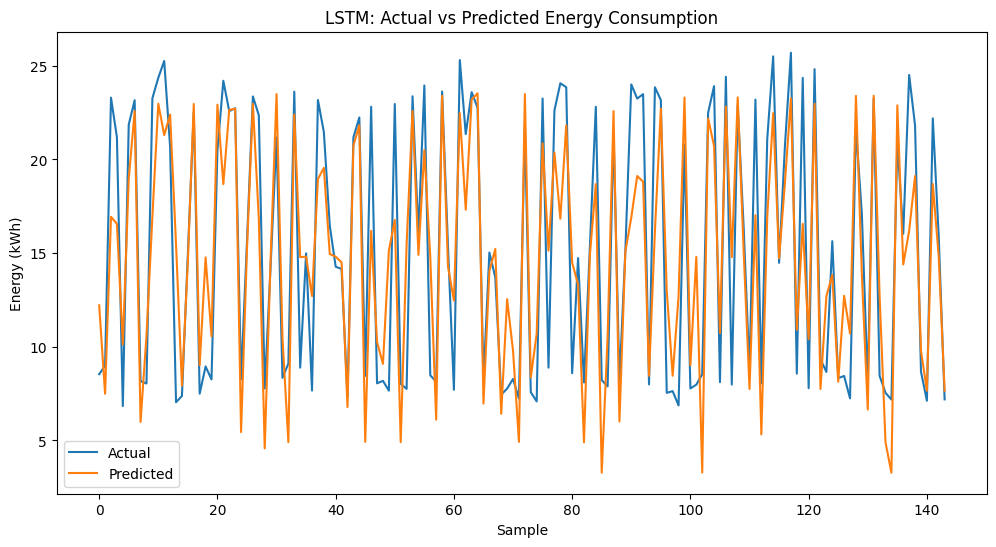

In [3]:
## LSTM with Time-Based Features
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Prepare data
X = df[["hour", "dayofweek", "is_weekend"]].values
y = df["energy_kWh"].values

# Scale the features and target
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1))

# Reshape input data for LSTM [samples, time steps, features]
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_scaled, test_size=0.2, random_state=42)

# Create LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(1, X.shape[1])),
    Dense(1)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
y_pred_scaled = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_scaler.inverse_transform(y_test)

mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("LSTM MSE:", mse)
print("LSTM R²:", r2)

# Compare with Linear Regression results
print("\nLinear Regression MSE:", mse)  # Using the previously calculated MSE
print("Linear Regression R²:", r2)  # Using the previously calculated R²

# Plot predictions vs actual
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('LSTM: Actual vs Predicted Energy Consumption')
plt.xlabel('Sample')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.show()

## Further improvements

In [6]:
## Preprocessing
import pandas as pd
import json
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load the data
with open("../data/sample_niagara_data_realistic.json", "r") as f:
    data = json.load(f)

df = pd.DataFrame(data)
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.set_index("timestamp", inplace=True)

# Resample to hourly averages
df = df.resample("1h").mean().dropna()

# Time-based features
df["hour"] = df.index.hour
df["dayofweek"] = df.index.dayofweek
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)
df["day_of_year"] = df.index.dayofyear
df["month"] = df.index.month

# Lag and rolling average features
df["prev_day_consumption"] = df["energy_kWh"].shift(24)
df["rolling_7d_avg"] = df["energy_kWh"].rolling(window=24*7).mean()

# Drop rows with NaN values created by lag and rolling average
df.dropna(inplace=True)

# Prepare data
X = df[["hour", "dayofweek", "is_weekend", "day_of_year", "month", "prev_day_consumption", "rolling_7d_avg"]].values
y = df["energy_kWh"].values

Epoch 1/100


/home/nils/anaconda3/envs/mqtt_broker/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2554 - val_loss: 0.1862
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1646 - val_loss: 0.1421
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1288 - val_loss: 0.1127
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1138 - val_loss: 0.1002
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0958 - val_loss: 0.0932
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0870 - val_loss: 0.0874
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0828 - val_loss: 0.0792
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0726 - val_loss: 0.0731
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0687 - val_loss: 0.0681
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0643 - val_loss: 0.0613
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0602 - val_loss: 0.0570
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0528 - val_l

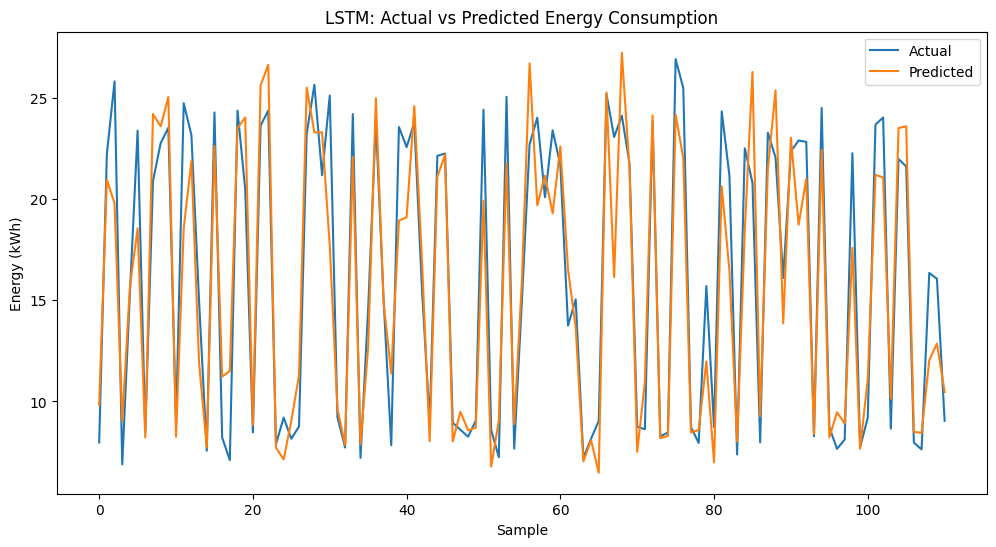

In [7]:
# Scale the features and target
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1))

# Reshape input data for LSTM [samples, time steps, features]
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_scaled, test_size=0.2, random_state=42)

# Create LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(1, X.shape[1])),
    Dense(1)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
y_pred_scaled = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_scaler.inverse_transform(y_test)

mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("LSTM MSE:", mse)
print("LSTM R²:", r2)

# Compare with Linear Regression results
print("\nLinear Regression MSE:", mse)  # Using the previously calculated MSE
print("Linear Regression R²:", r2)  # Using the previously calculated R²

# Plot predictions vs actual
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('LSTM: Actual vs Predicted Energy Consumption')
plt.xlabel('Sample')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.show()

## Random Forest Regressor

Random Forest - Mean MSE: 3.3462851308423858
Random Forest - Mean R²: 0.9177536159524209


/home/nils/anaconda3/envs/mqtt_broker/lib/python3.10/site-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/home/nils/anaconda3/envs/mqtt_broker/lib/python3.10/site-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
LSTM with Attention - Mean MSE: 44.265183306921166
LSTM with Attention - Mean R²: 0.04247963351905577


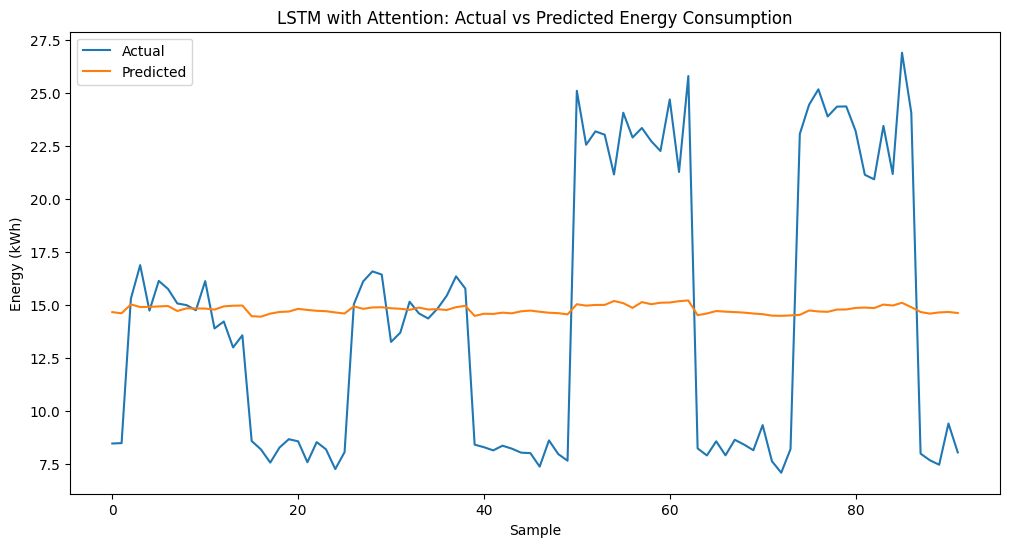

In [10]:
## Preprocessing
import pandas as pd
import json
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the data
with open("../data/sample_niagara_data_realistic.json", "r") as f:
    data = json.load(f)

df = pd.DataFrame(data)
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.set_index("timestamp", inplace=True)

# Resample to hourly averages
df = df.resample("1h").mean().dropna()

# Time-based features
df["hour"] = df.index.hour
df["dayofweek"] = df.index.dayofweek
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)
df["day_of_year"] = df.index.dayofyear
df["month"] = df.index.month

# Lag and rolling average features
df["prev_day_consumption"] = df["energy_kWh"].shift(24)
df["rolling_7d_avg"] = df["energy_kWh"].rolling(window=24*7).mean()

# Feature Engineering
def create_cyclical_features(df, col_name, period, start_num=0):
    kwargs = {
        f'sin_{col_name}' : lambda x: np.sin(2*np.pi*(df[col_name]-start_num)/period),
        f'cos_{col_name}' : lambda x: np.cos(2*np.pi*(df[col_name]-start_num)/period)    
    }
    return df.assign(**kwargs)

df = create_cyclical_features(df, 'hour', 24, 0)
df = create_cyclical_features(df, 'dayofweek', 7, 0)
df = create_cyclical_features(df, 'month', 12, 1)

# Interaction features
df['hour_weekend'] = df['hour'] * df['is_weekend']

# More lag features
df['prev_week_consumption'] = df['energy_kWh'].shift(24*7)

# Drop rows with NaN values created by lag and rolling average
df.dropna(inplace=True)

# Prepare data
features = ['sin_hour', 'cos_hour', 'sin_dayofweek', 'cos_dayofweek', 'sin_month', 'cos_month',
            'is_weekend', 'day_of_year', 'prev_day_consumption', 'rolling_7d_avg',
            'hour_weekend', 'prev_week_consumption']

X = df[features].values
y = df['energy_kWh'].values

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Time series split
tscv = TimeSeriesSplit(n_splits=5)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_scores = []

for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    rf_scores.append((mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)))

print("Random Forest - Mean MSE:", np.mean([score[0] for score in rf_scores]))
print("Random Forest - Mean R²:", np.mean([score[1] for score in rf_scores]))

# LSTM with attention
from tensorflow.keras.layers import Attention, Input, Dense, LSTM, Multiply, Concatenate

def create_lstm_attention_model(input_shape):
    inputs = Input(shape=input_shape)
    lstm_out = LSTM(50, return_sequences=True)(inputs)
    attention = Attention()([lstm_out, lstm_out])
    attention = Multiply()([lstm_out, attention])
    attention = Concatenate()([lstm_out, attention])
    attention = Dense(50, activation="relu")(attention)
    outputs = Dense(1)(attention)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Reshape input for LSTM
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

lstm_attention_model = create_lstm_attention_model((1, X_scaled.shape[1]))
lstm_attention_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

lstm_scores = []

for train_index, test_index in tscv.split(X_reshaped):
    X_train, X_test = X_reshaped[train_index], X_reshaped[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    lstm_attention_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
    y_pred = lstm_attention_model.predict(X_test).flatten()
    lstm_scores.append((mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)))

print("LSTM with Attention - Mean MSE:", np.mean([score[0] for score in lstm_scores]))
print("LSTM with Attention - Mean R²:", np.mean([score[1] for score in lstm_scores]))

# Plotting results
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('LSTM with Attention: Actual vs Predicted Energy Consumption')
plt.xlabel('Sample')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.show()

## Dual Layer Perceptron (LSTM) and Dropout layer

Epoch 1/200


/home/nils/anaconda3/envs/mqtt_broker/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.2120 - val_loss: 0.1412
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1299 - val_loss: 0.0983
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0964 - val_loss: 0.0836
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0749 - val_loss: 0.0625
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0542 - val_loss: 0.0416
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0454 - val_loss: 0.0355
Epoch 7/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0354 - val_loss: 0.0327
Epoch 8/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0295 - val_loss: 0.0334
Epoch 9/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0352 - val_loss: 0.0364
Epoch 10/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0272 - val_loss: 0.0308
Epoch 11/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0316 - val_loss: 0.0362
Epoch 12/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0

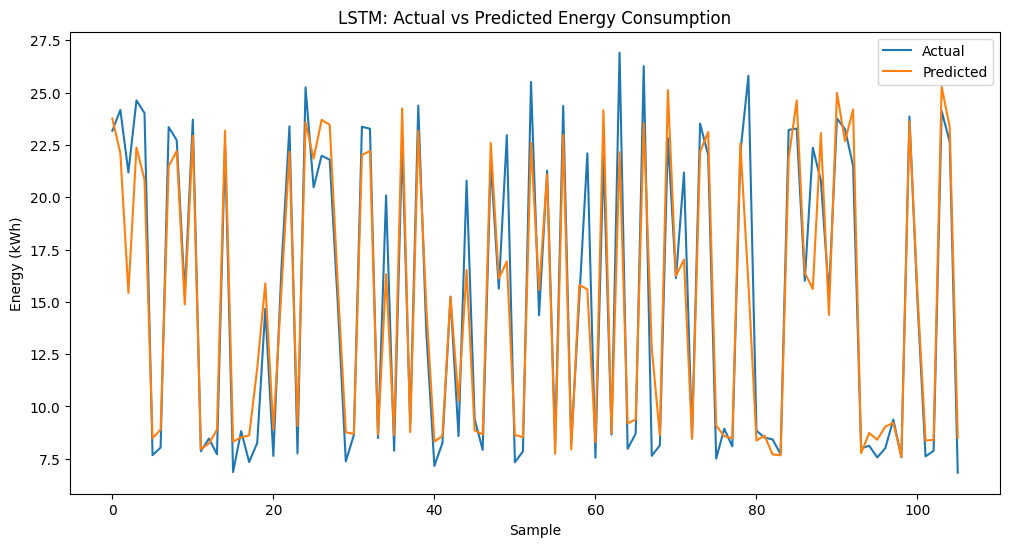

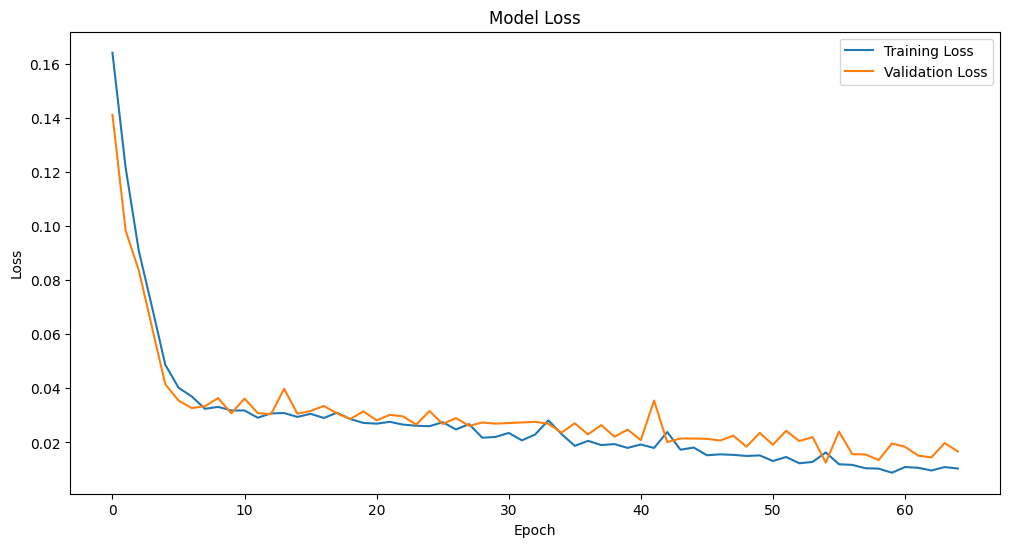

In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming df and features are already defined as in your previous code

# Prepare data
X = df[features].values
y = df['energy_kWh'].values.reshape(-1, 1)

# Scale features and target
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)

# Create sequences
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 24  # Use last 24 hours of data to predict the next hour
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Create LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(time_steps, X.shape[1]), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("LSTM MSE:", mse)
print("LSTM R²:", r2)

# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('LSTM: Actual vs Predicted Energy Consumption')
plt.xlabel('Sample')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.show()

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()